# Опыты Франка - Герца

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy import signal
from scipy.fft import fft, ifft, fftfreq, fftshift
from findiff import FinDiff
from scipy import constants as const

In [211]:
v_inh = [4, 6, 8]
diff_v = {v: 0 for v in v_inh}
x_v = {v: 0 for v in v_inh}
maximums_v = {v: 0 for v in v_inh}
distances_v = {v: [] for v in v_inh}
rate = 5000

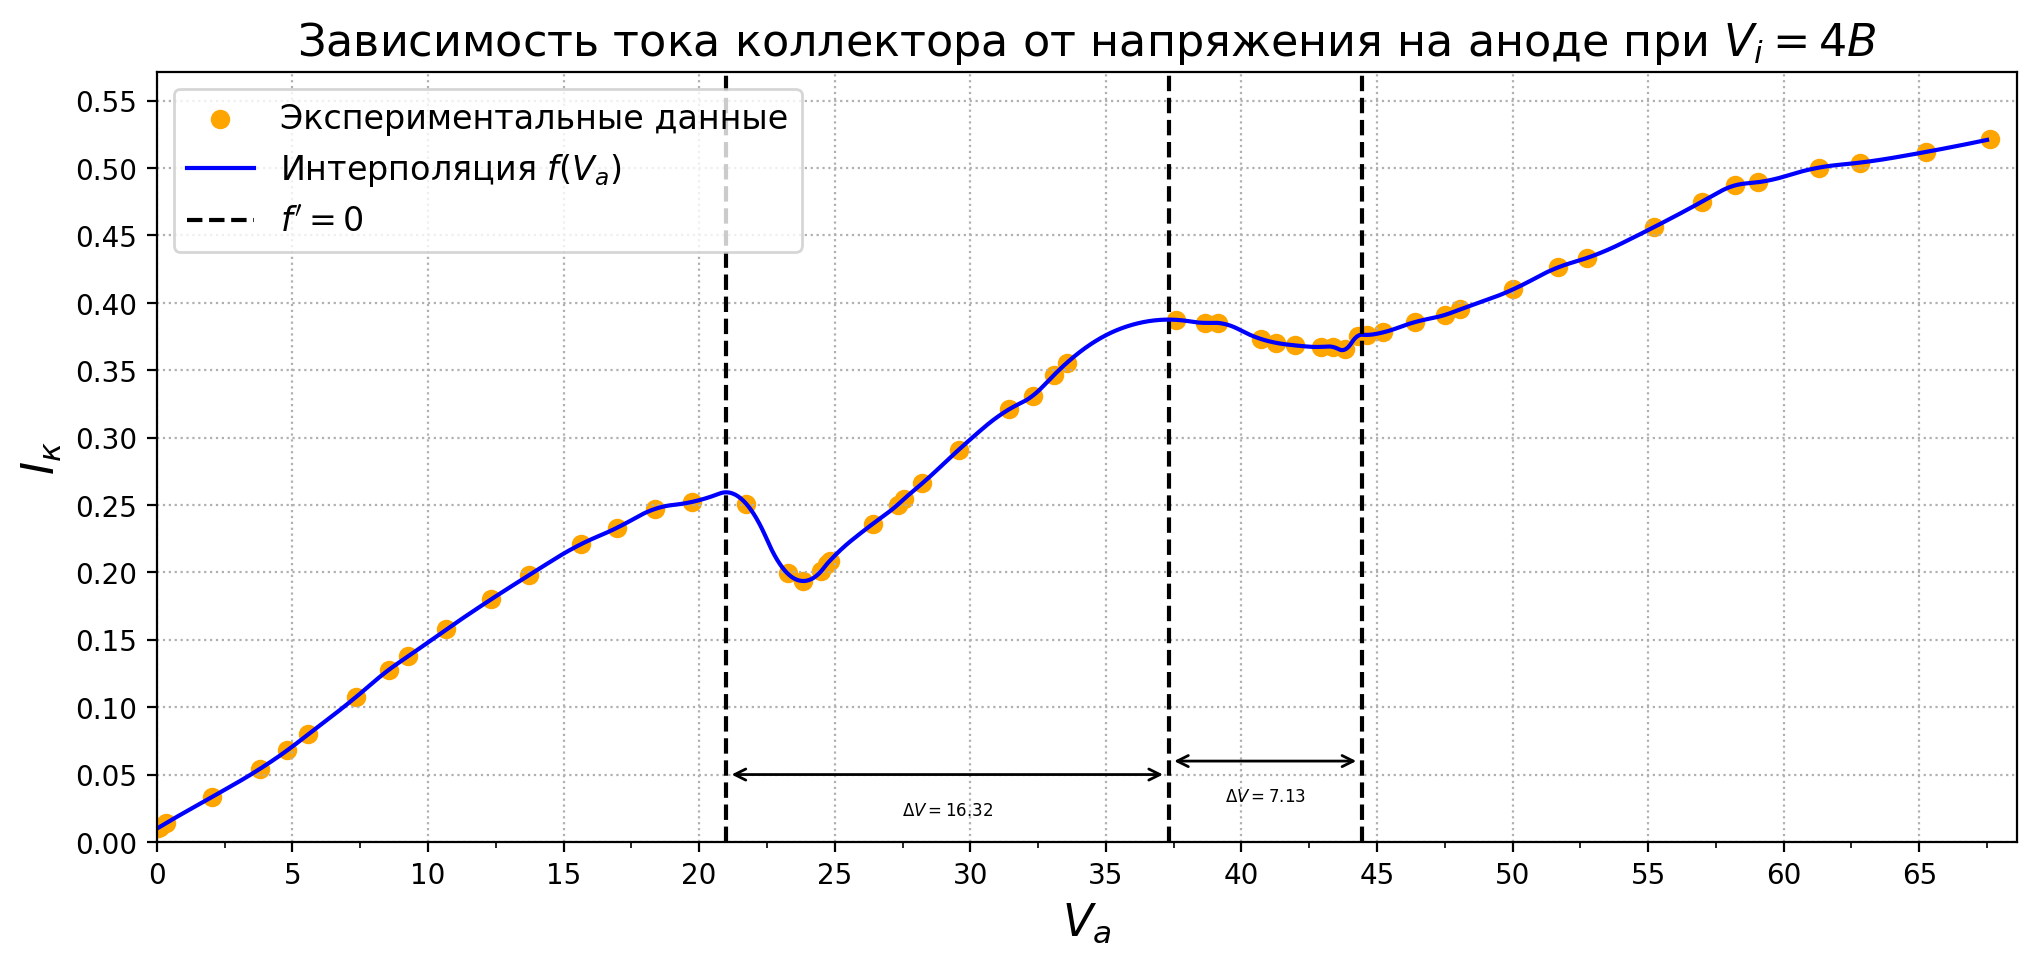

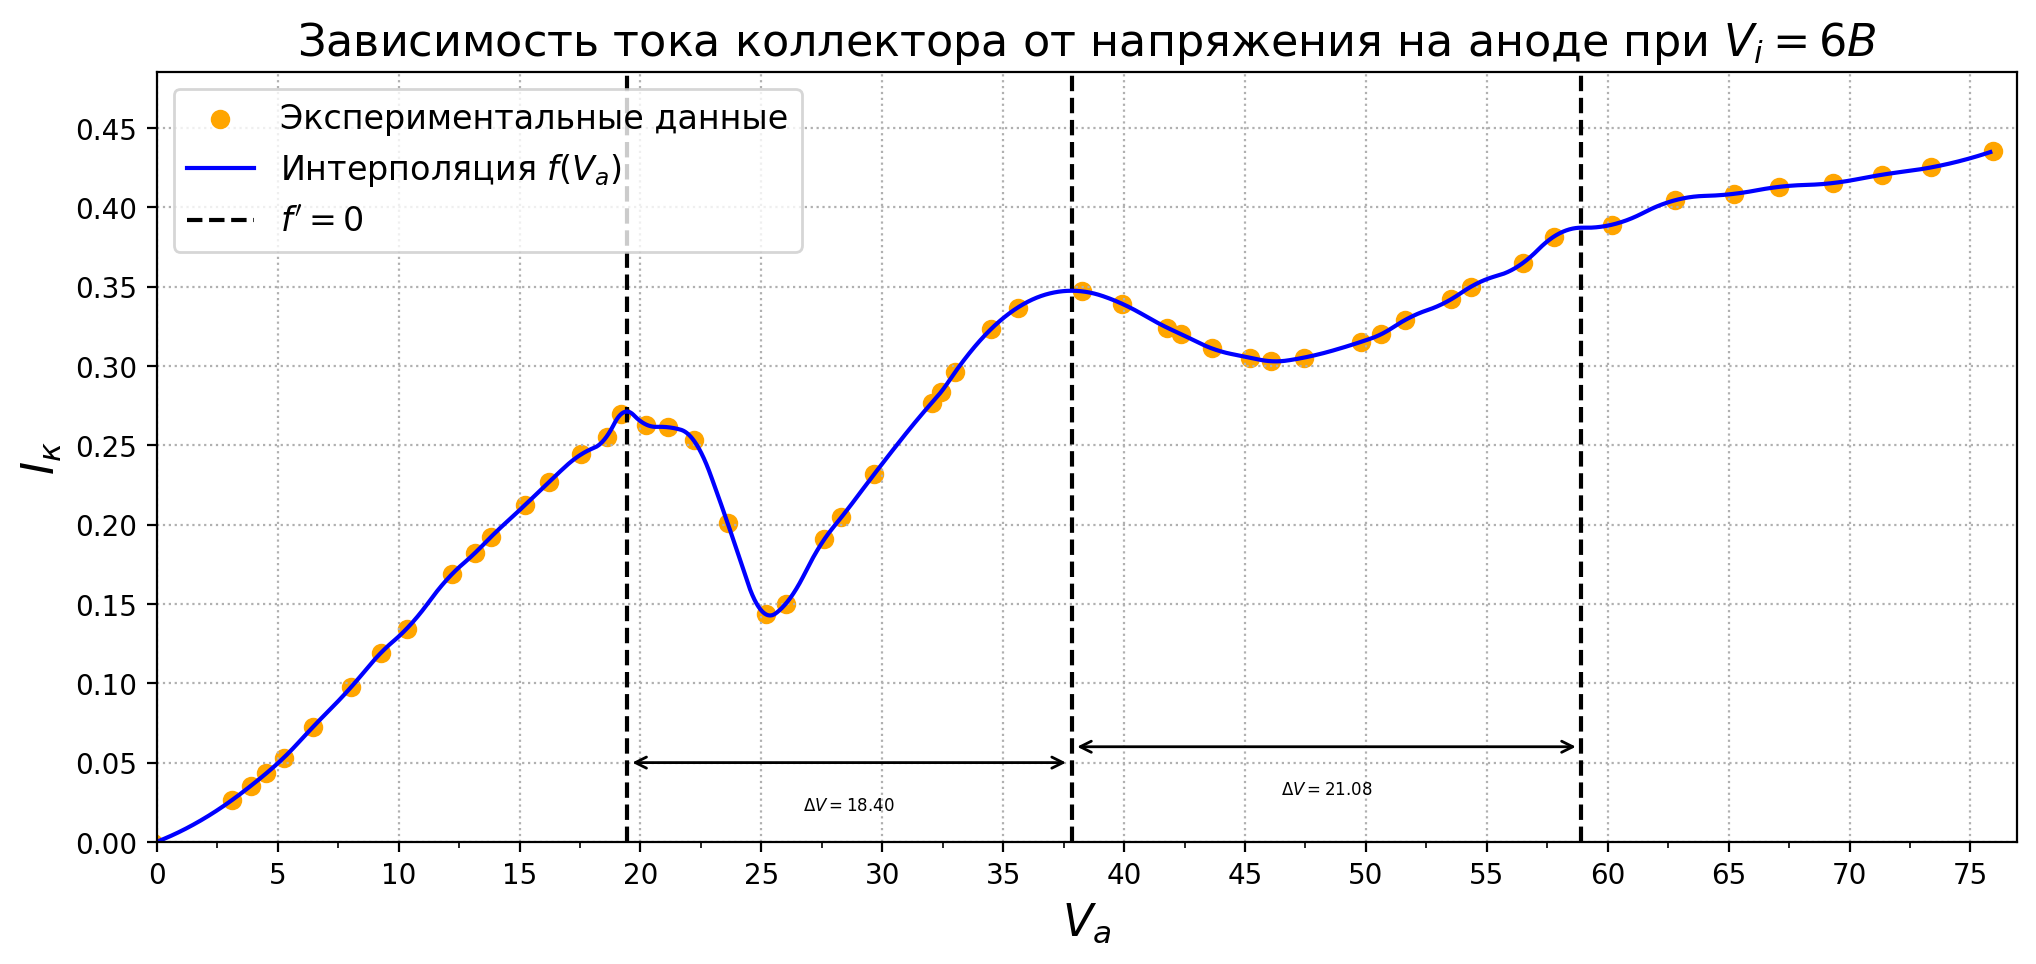

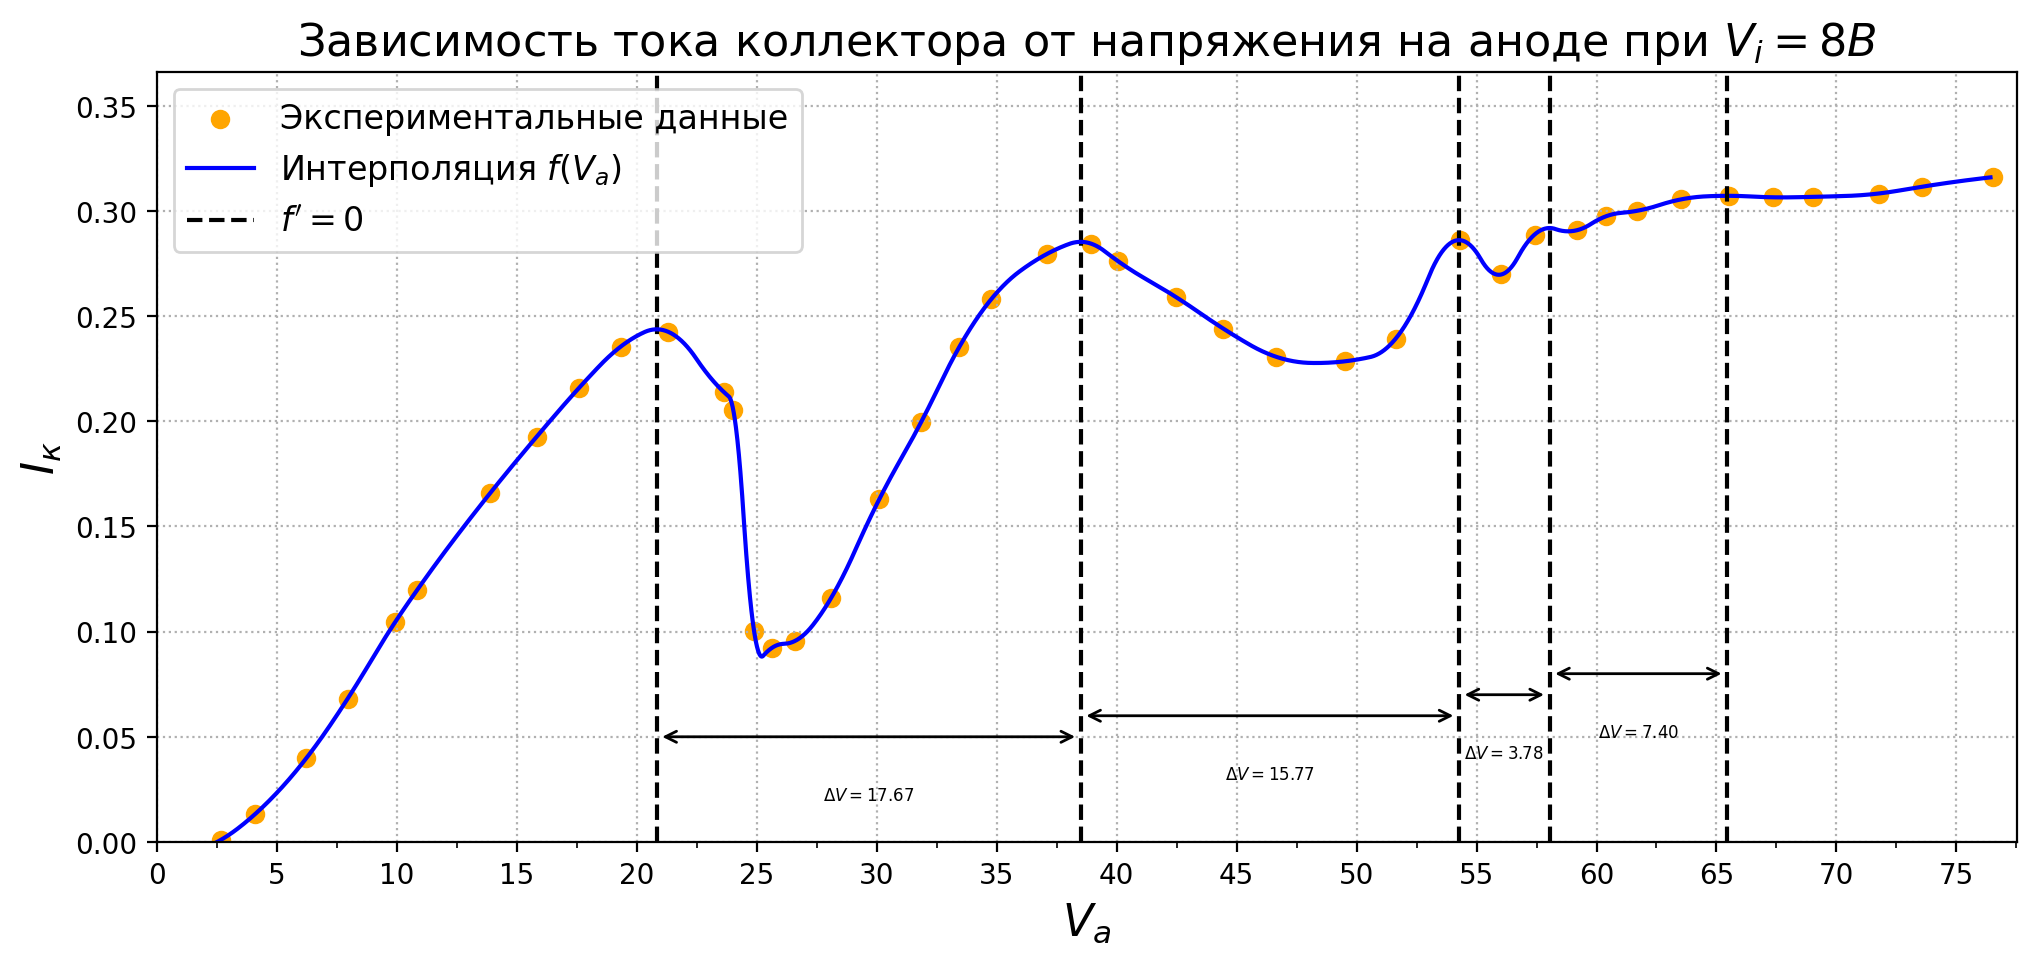

In [212]:
for v in v_inh:
    data = pd.read_csv(f"{v}v.csv")
    interpolation_function = interp1d(data.V, data.I, kind = 'quadratic')
    x_line = np.linspace(np.min(data.V) + 0.1, np.max(data.V) - 0.1, rate)
    d_dx = FinDiff(0, x_line[1] - x_line[0], 1)
    interpolation_line = interpolation_function(x_line) 
    interpolation_function_d = d_dx(interpolation_line)
    diff_v[v] = interpolation_function_d
    x_v[v] = x_line
    peaks, _ = signal.find_peaks(interpolation_line, 
                                 distance = 150)
    plt.figure(figsize = (12, 5), dpi = 200)
    for p in peaks[:-1]:
        plt.axvline(x_line[p], color = 'black', linestyle = '--')
    
    arrow_y_pos = np.arange(len(peaks)) * 0.01 + 0.05
    for i in range(len(peaks) - 1):
        dist = x_line[peaks[i + 1]] - x_line[peaks[i]]
        distances_v[v].append(dist)
        plt.annotate("", 
                     xy=(x_line[peaks[i]], arrow_y_pos[i]), 
                     xytext=(x_line[peaks[i + 1]], arrow_y_pos[i]), 
                     arrowprops=dict(arrowstyle="<->"))
        plt.text(x_line[peaks[i]] + dist / 2, 
                 arrow_y_pos[i] - 0.03, 
                 f'$\Delta V = {dist:.2f}$',
                 horizontalalignment='center',
                 fontsize = 6)
    plt.scatter(data.V, data.I, label = 'Экспериментальные данные', color = 'orange')
    plt.plot(x_line, interpolation_line, label = 'Интерполяция $f(V_{а})$', color = 'blue')
    plt.axvline(x_line[peaks[-1]], color = 'black', linestyle = '--', label = '$f^\prime = 0$')
    plt.title(f'Зависимость тока коллектора от напряжения на аноде при $V_i = {v} В$',
              fontsize = 16)
    max_lim_y, max_lim_x = data.I.max() + 0.05, data.V.max() + 1
    plt.yticks(np.arange(0, max_lim_y + 0.05, 0.05))
    plt.xticks(np.arange(0, max_lim_x + 5, 2.5), minor = True)
    plt.xticks(np.arange(0, max_lim_x + 5, 5))
    plt.ylim(0, max_lim_y)
    plt.xlim(0, max_lim_x)
    plt.grid(ls = ':')
    plt.xlabel("$V_{a}$", fontsize = 16)
    plt.ylabel("$I_{к}$", fontsize = 16)
    plt.legend(fontsize = 12, loc = 'upper left')

In [217]:
for v in v_inh:
    print(v)
    print(distances_v[v])

4
[16.322346469293855, 7.128369673934785]
6
[18.396991398279656, 21.08368073614723]
8
[17.669081816363274, 15.765549109821961, 3.776363272654528, 7.399215843168648]


-1666.6666666666667
-1666.6666666666667
-1250.0


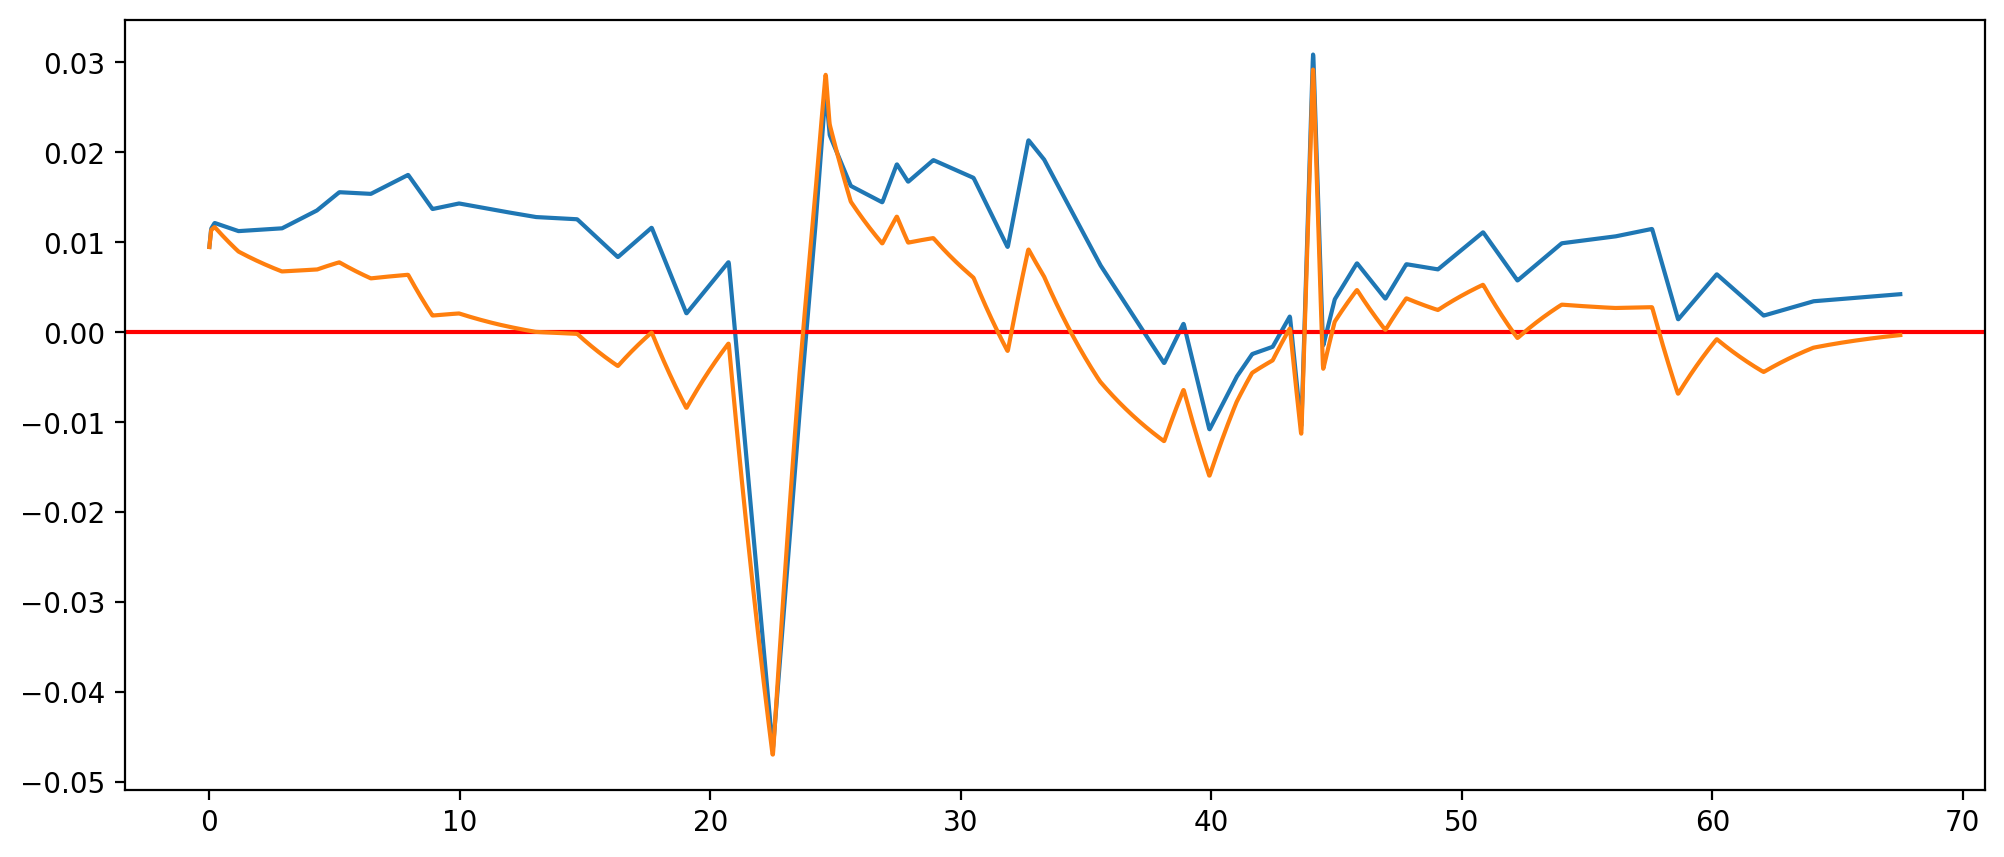

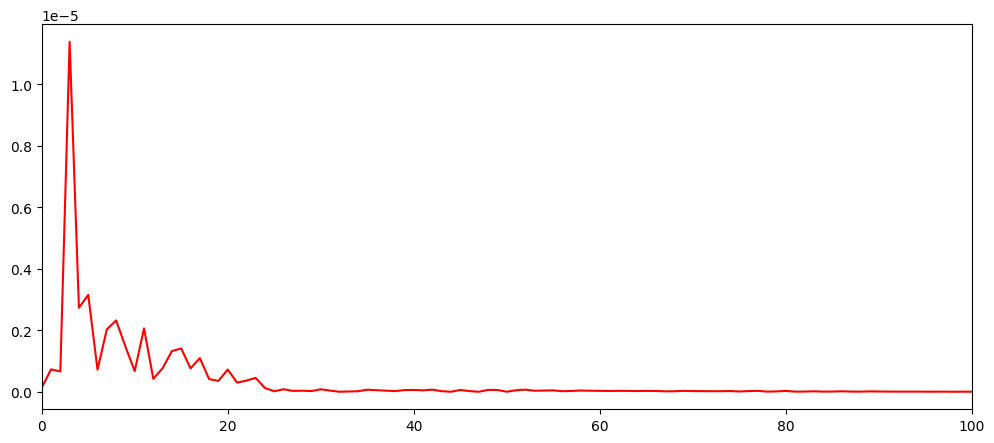

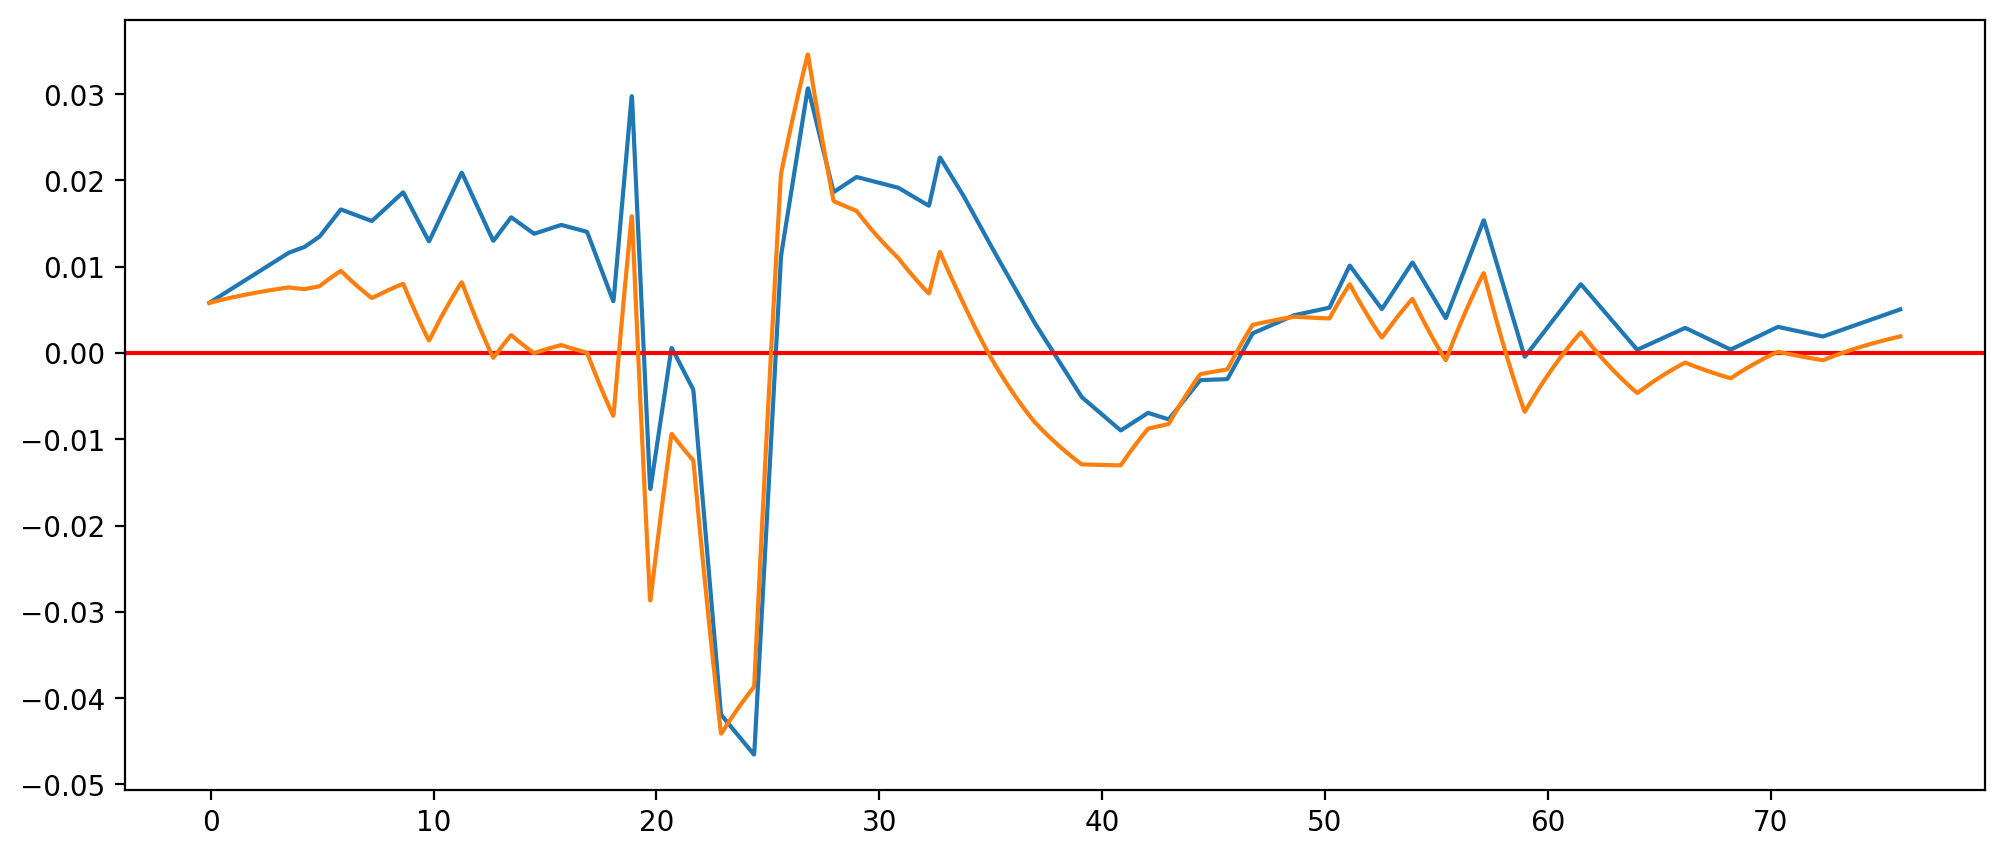

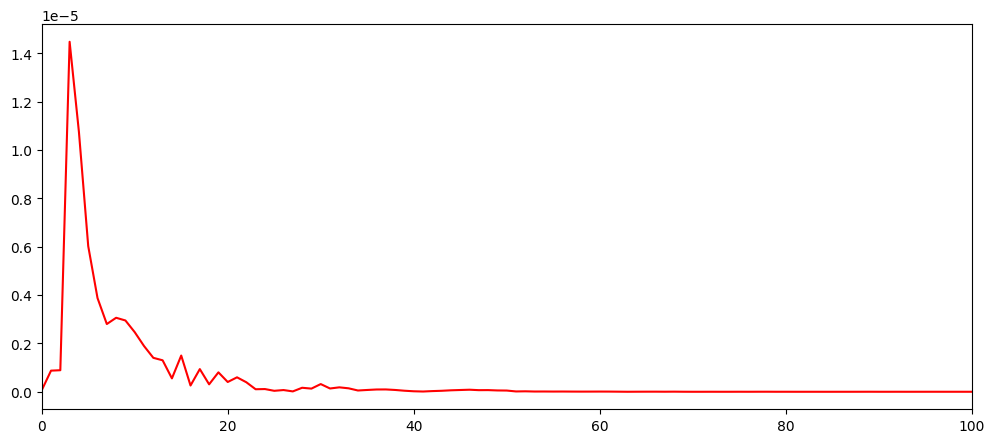

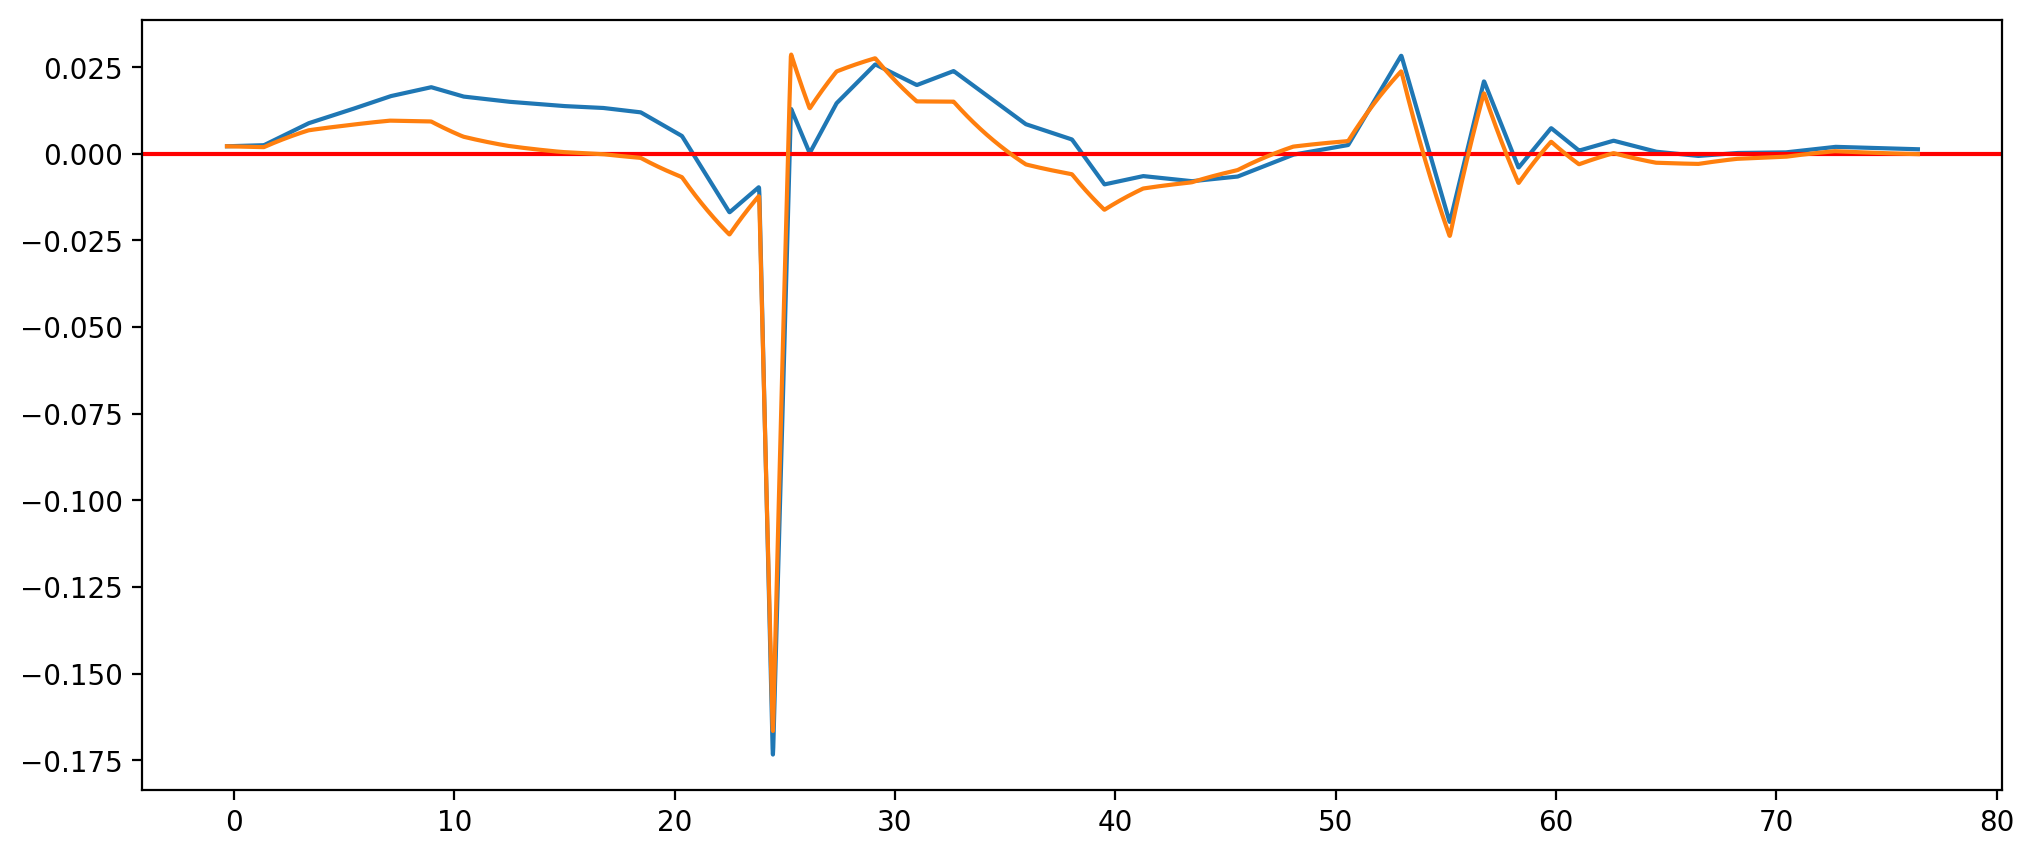

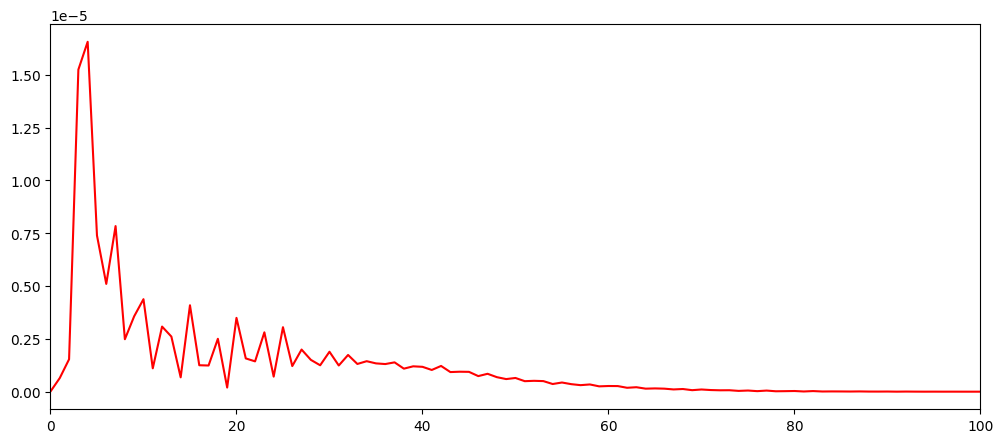

In [222]:
for v in v_inh:
    plt.figure(figsize = (12, 5), dpi  = 200)
    plt.plot(x_v[v], diff_v[v])
    plt.axhline(0, color = 'red')
    sos = signal.butter(1, 2, 'hp', fs = 5000, output='sos')
    filtered = signal.sosfilt(sos, diff_v[v])
    plt.plot(x_v[v], filtered)
    
    plt.figure(figsize = (12, 5))
    
    
    periodogram = np.abs(fft(filtered))**2 / (rate * len(filtered))
    frequencies = fftfreq(len(filtered), d=1/rate)
    plt.plot(fftshift(frequencies), fftshift(periodogram), color='red')
    plt.xlim(0, 100)
    print(rate / fftshift(frequencies)[np.argmax(fftshift(periodogram))])